#Preparing the data

In [ ]:
from google.colab import files
uploaded = files.upload()

the data set

https://drive.google.com/file/d/1_IUBFAKgjpeBt-9cx4NZ9DRsPTRgErKT/view?usp=sharing

In [ ]:
import pandas as pd
import io
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


dataframe = pd.read_csv(io.BytesIO(uploaded['Train.csv']))
print(dataframe)

      Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0                   D           Flight                    4                2   
1                   F           Flight                    4                5   
2                   A           Flight                    2                2   
3                   B           Flight                    3                3   
4                   C           Flight                    2                2   
...               ...              ...                  ...              ...   
10994               A             Ship                    4                1   
10995               B             Ship                    4                1   
10996               C             Ship                    5                4   
10997               F             Ship                    5                2   
10998               D             Ship                    2                5   

       Cost_of_the_Product  Prior_purch

In [ ]:
dataframe.shape

(10999, 10)

In [ ]:
dataframe.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,44,1233,1
1,F,Flight,4,5,216,2,low,59,3088,1
2,A,Flight,2,2,183,4,low,48,3374,1
3,B,Flight,3,3,176,4,medium,10,1177,1
4,C,Flight,2,2,184,3,medium,46,2484,1


In [ ]:
dataframe.rename(columns={'Reached.on.Time_Y.N':'isLate'}, inplace=True)
dataframe.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,isLate
0,D,Flight,4,2,177,3,low,44,1233,1
1,F,Flight,4,5,216,2,low,59,3088,1
2,A,Flight,2,2,183,4,low,48,3374,1
3,B,Flight,3,3,176,4,medium,10,1177,1
4,C,Flight,2,2,184,3,medium,46,2484,1


In [ ]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 8799 samples for training and 2200 for validation


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("isLate")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [ ]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Warehouse_block': <tf.Tensor: shape=(), dtype=string, numpy=b'D'>, 'Mode_of_Shipment': <tf.Tensor: shape=(), dtype=string, numpy=b'Flight'>, 'Customer_care_calls': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'Customer_rating': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'Cost_of_the_Product': <tf.Tensor: shape=(), dtype=int64, numpy=262>, 'Prior_purchases': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'Product_importance': <tf.Tensor: shape=(), dtype=string, numpy=b'medium'>, 'Discount_offered': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'Weight_in_gms': <tf.Tensor: shape=(), dtype=int64, numpy=5738>}
Target: tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [ ]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

#Build a model

In [ ]:
# Categorical features encoded as integers
customer_rating = keras.Input(shape=(1,), name="Customer_rating", dtype="int64")

# Categorical feature encoded as string
warehouse_block = keras.Input(shape=(1,), name="Warehouse_block", dtype="string")
mode_of_shipment = keras.Input(shape=(1,), name="Mode_of_Shipment", dtype="string")
product_importance = keras.Input(shape=(1,), name="Product_importance", dtype="string")

# Numerical features
customer_care_calls = keras.Input(shape=(1,), name="Customer_care_calls")
cost_of_the_product = keras.Input(shape=(1,), name="Cost_of_the_Product")
prior_purchases = keras.Input(shape=(1,), name="Prior_purchases")
discount_offered = keras.Input(shape=(1,), name="Discount_offered")
weight_in_gms = keras.Input(shape=(1,), name="Weight_in_gms")

all_inputs = [
    customer_rating,
    warehouse_block,
    mode_of_shipment,
    product_importance,
    customer_care_calls,
    cost_of_the_product,
    prior_purchases,
    discount_offered,
    weight_in_gms
]

# Integer categorical features
rating_encoded = encode_categorical_feature(customer_rating, "Customer_rating", train_ds, False)

# String categorical features
warehouse_encoded = encode_categorical_feature(warehouse_block, "Warehouse_block", train_ds, True)
mood_encoded = encode_categorical_feature(mode_of_shipment, "Mode_of_Shipment", train_ds, True)
importance_encoded = encode_categorical_feature(product_importance, "Product_importance", train_ds, True)
# Numerical features
care_encoded = encode_numerical_feature(customer_care_calls, "Customer_care_calls", train_ds)
cost_encoded = encode_numerical_feature(cost_of_the_product, "Cost_of_the_Product", train_ds)
purchases_encoded = encode_numerical_feature(prior_purchases, "Prior_purchases", train_ds)
discount_encoded = encode_numerical_feature(discount_offered, "Discount_offered", train_ds)
weight_encoded = encode_numerical_feature(weight_in_gms, "Weight_in_gms", train_ds)

all_features = layers.concatenate(
    [
        rating_encoded,
        warehouse_encoded,
        mood_encoded,
        importance_encoded,
        care_encoded,
        cost_encoded,
        purchases_encoded,
        discount_encoded,
        weight_encoded
    ]
)
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.25)(x)
output = layers.Dense(1, activation="softmax")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

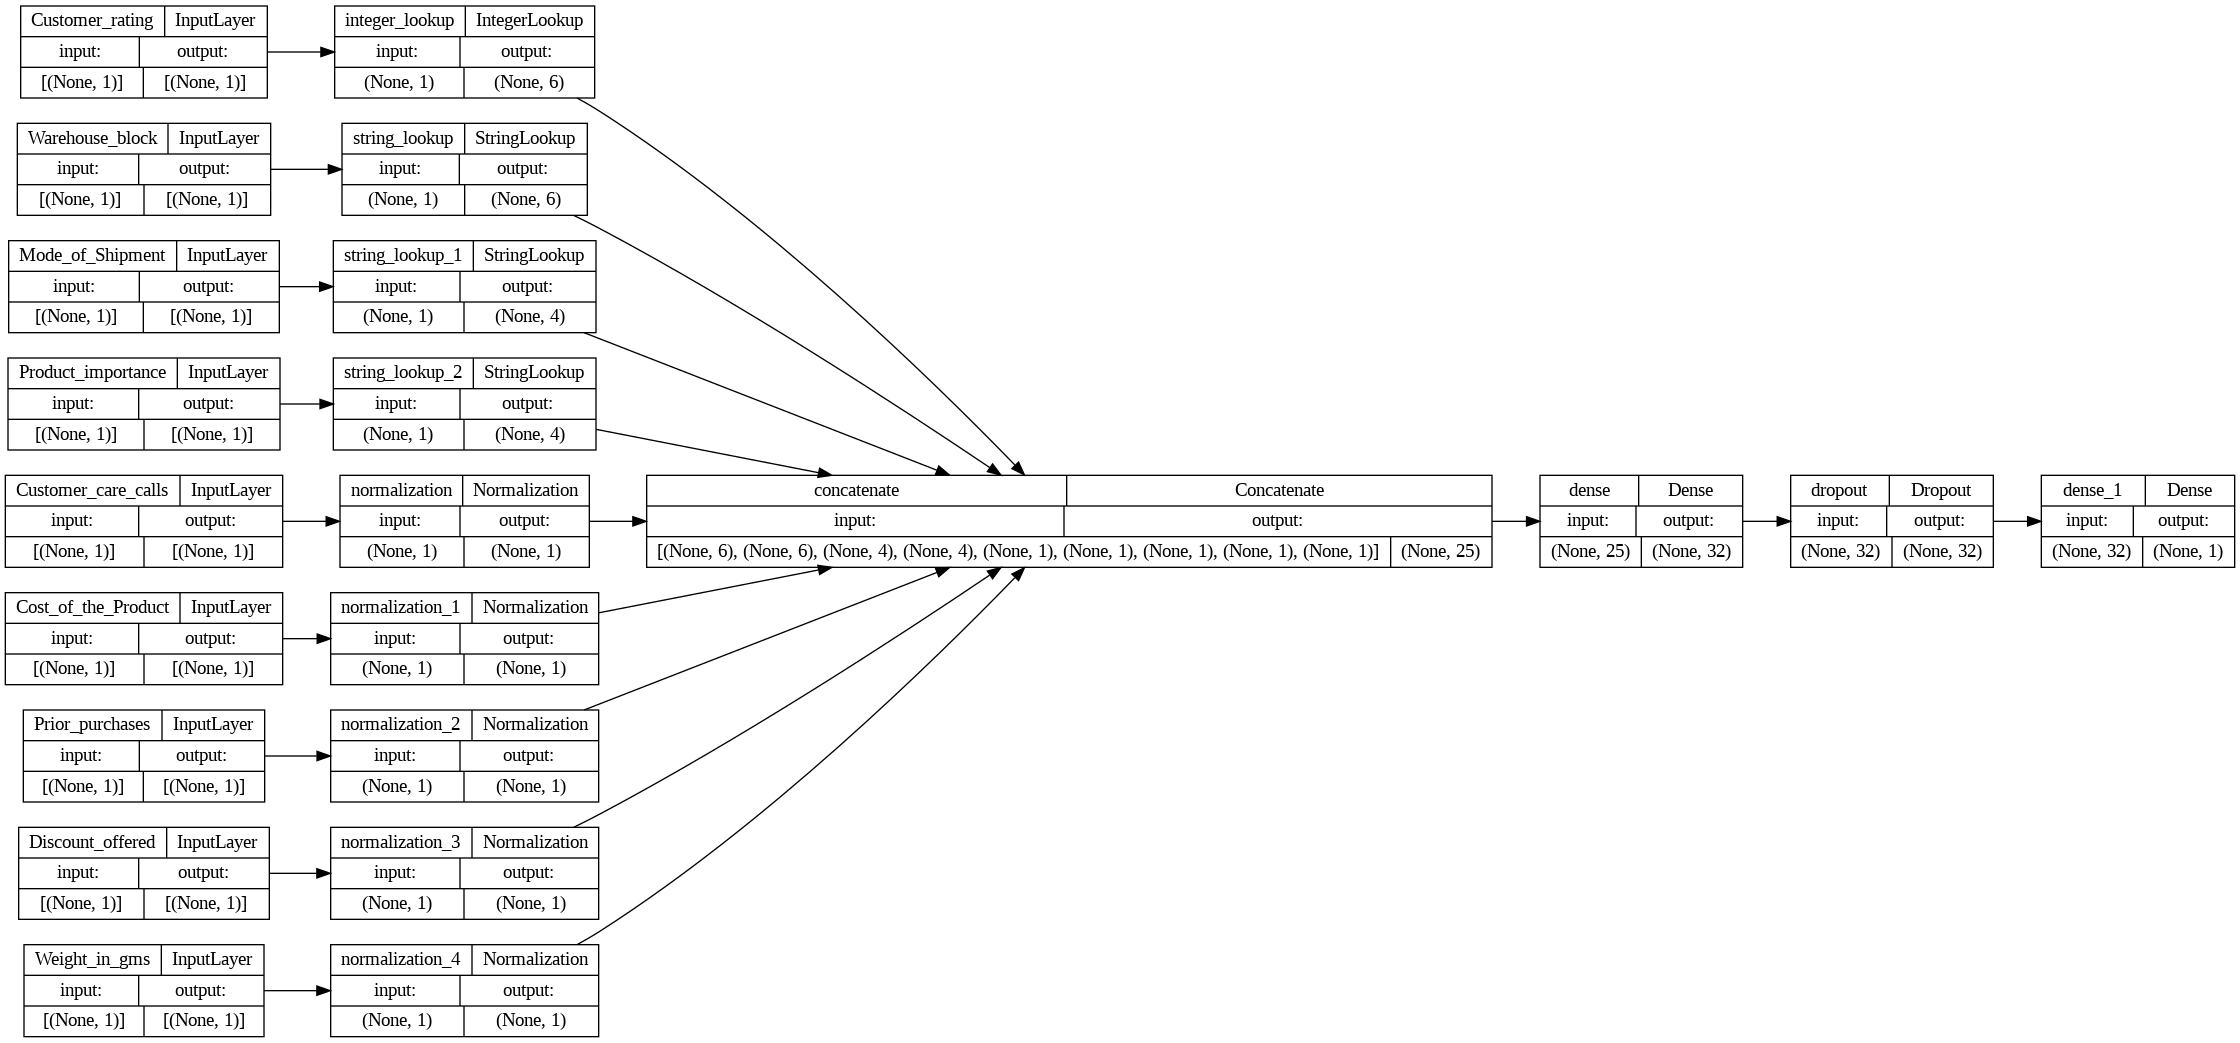

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

#Train the model

In [ ]:
model.fit(train_ds, epochs=126, validation_data=val_ds)

Epoch 1/126
275/275 [==============================] - 3s 4ms/step - loss: 0.6174 - accuracy: 0.5977 - val_loss: 0.5664 - val_accuracy: 0.5927
Epoch 2/126
275/275 [==============================] - 1s 3ms/step - loss: 0.5557 - accuracy: 0.5977 - val_loss: 0.5529 - val_accuracy: 0.5927
Epoch 3/126
275/275 [==============================] - 1s 3ms/step - loss: 0.5407 - accuracy: 0.5977 - val_loss: 0.5480 - val_accuracy: 0.5927
Epoch 4/126
275/275 [==============================] - 1s 3ms/step - loss: 0.5352 - accuracy: 0.5977 - val_loss: 0.5437 - val_accuracy: 0.5927
Epoch 5/126
275/275 [==============================] - 1s 3ms/step - loss: 0.5300 - accuracy: 0.5977 - val_loss: 0.5412 - val_accuracy: 0.5927
Epoch 6/126
275/275 [==============================] - 1s 3ms/step - loss: 0.5278 - accuracy: 0.5977 - val_loss: 0.5393 - val_accuracy: 0.5927
Epoch 7/126
275/275 [==============================] - 1s 3ms/step - loss: 0.5241 - accuracy: 0.5977 - val_loss: 0.5383 - val_accuracy: 0.5927

#Inference on new data

In [ ]:
sample = {

    "Customer_rating" : 3,
    "Warehouse_block" : "B",
    "Mode_of_Shipment" : "Flight",
    "Product_importance" : "medium",
    "Customer_care_calls" : 3 ,
    "Cost_of_the_Product" : 176,
    "Prior_purchases" : 4,
    "Discount_offered": 10,
    "Weight_in_gms" :  1177
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular shipment had a %.1f percent probability "
    "of been late, as evaluated by our model." % (100 * predictions[0][0],)
)

1/1 [==============================] - 0s 29ms/step
This particular shipment had a 100.0 percent probability of been late, as evaluated by our model.
